In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random


In [3]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    # if len(paths) == 2800:
    #      break
print('Dataset is Loaded')
      
        

Dataset is Loaded


In [4]:
len(paths)

5600

In [5]:
paths[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [6]:
def extract_features(file_path, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # time steps first

features = []
valid_labels = []

for i, path in enumerate(paths):
    try:
        mfcc_features = extract_features(path)
        features.append(mfcc_features)
        valid_labels.append(labels[i])
    except Exception as e:
        print(f"Error extracting {path}: {e}")

print(f"Successfully extracted {len(features)} features")
labels = valid_labels


Successfully extracted 5600 features


In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Example feature list (Ensure `features` and `labels` are defined before running)
max_len = max(len(f) for f in features)
X = pad_sequences(features, maxlen=max_len, padding='post')

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
y = tf.keras.utils.to_categorical(y)

print(f"Feature shape: {X.shape}")
print(f"Label shape: {y.shape}")


Feature shape: (5600, 129, 40)
Label shape: (5600, 7)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(GRU(
    64, return_sequences=True,
    kernel_regularizer=l2(0.002), recurrent_regularizer=l2(0.002)
))
model.add(Dropout(0.5))

model.add(GRU(
    32,
    kernel_regularizer=l2(0.002), recurrent_regularizer=l2(0.002)
))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.002)))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:



early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=45,
    batch_size=64,
    validation_data=(X_test, y_test),
    validation_split=0.2,
    

)


Epoch 1/45
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.1414 - loss: 2.3396 - val_accuracy: 0.1554 - val_loss: 2.0985
Epoch 2/45
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.1868 - loss: 2.0140 - val_accuracy: 0.2795 - val_loss: 1.5867
Epoch 3/45
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.2926 - loss: 1.5545 - val_accuracy: 0.3000 - val_loss: 1.4581
Epoch 4/45
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.3102 - loss: 1.4377 - val_accuracy: 0.3598 - val_loss: 1.3888
Epoch 5/45
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.3640 - loss: 1.3719 - val_accuracy: 0.5321 - val_loss: 1.1077
Epoch 6/45
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.5744 - loss: 1.0472 - val_accuracy: 0.7089 - val_loss: 0.7685
Epoch 7/45
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.6744 - loss: 0.8055 - val_accuracy: 0.6473 - val_loss: 0.8560
Epoch 8/45
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.7169 - loss: 0.7447 - val_accuracy:

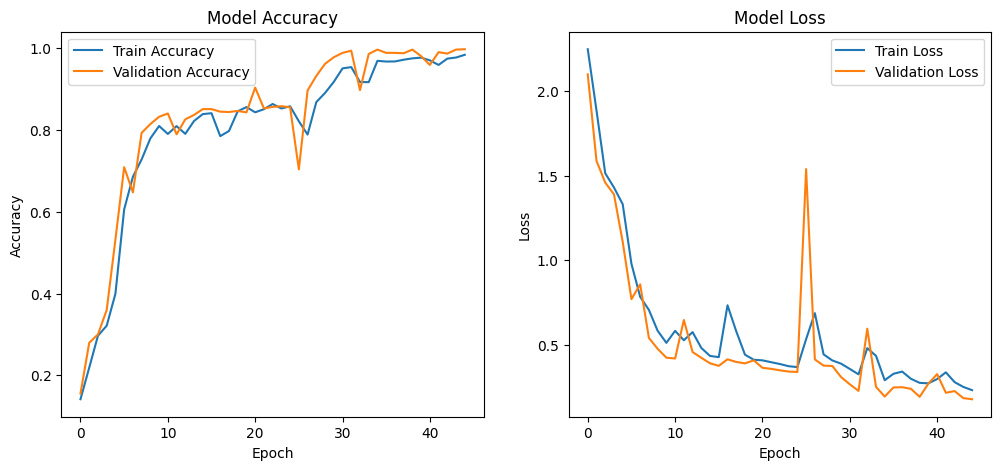

In [11]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       1.00      0.99      0.99       160
     disgust       1.00      0.99      1.00       160
        fear       1.00      1.00      1.00       160
       happy       1.00      1.00      1.00       160
     neutral       1.00      1.00      1.00       160
          ps       0.99      1.00      0.99       160
         sad       0.99      1.00      1.00       160

    accuracy                           1.00      1120
   macro avg       1.00      1.00      1.00      1120
weighted avg       1.00      1.00      1.00      1120



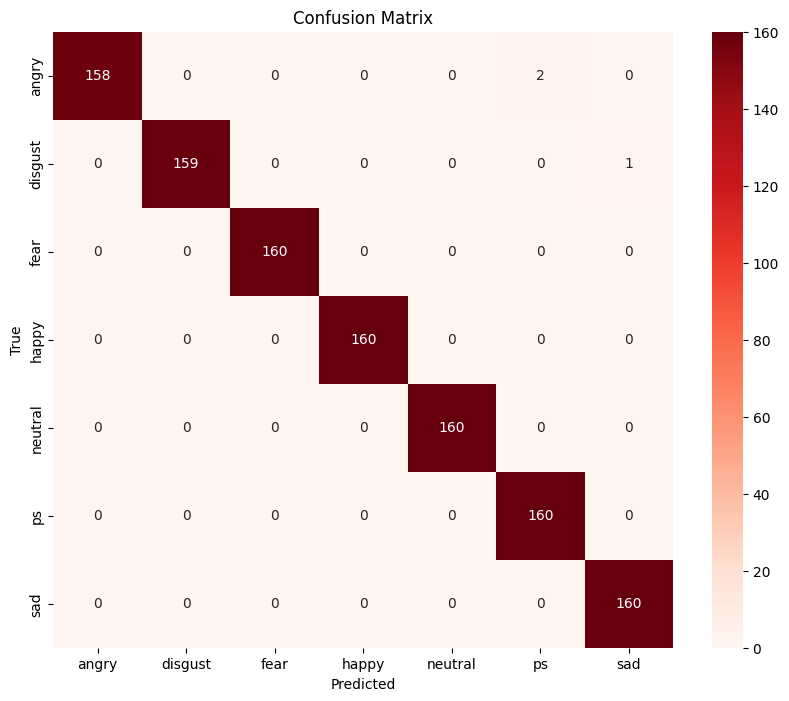

In [12]:
# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


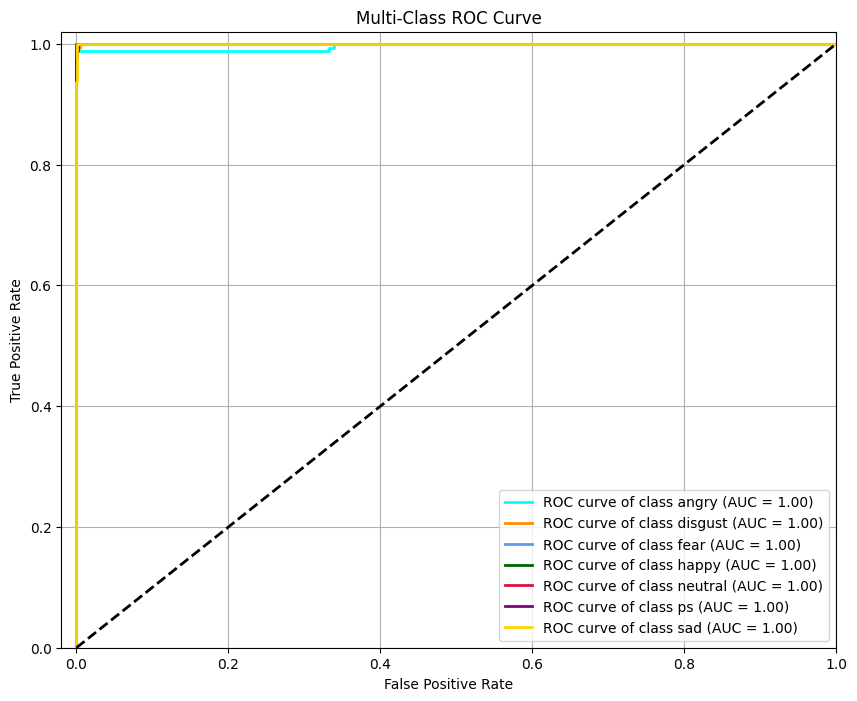

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels again (precaution)
y_test_bin = y_test
y_score = y_pred
n_classes = y_test_bin.shape[1]
class_names = le.classes_

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'crimson', 'purple', 'gold'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
